In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(101)

import tensorflow as tf
tf.__version__
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [2]:
data = pd.read_csv('input/skin_cancer_mnist/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]
X.head(5)

,image_full_name,dx,lesion_id
0,ISIC_0027419.jpg,bkl,HAM_0000118
1,ISIC_0025030.jpg,bkl,HAM_0000118
2,ISIC_0026769.jpg,bkl,HAM_0002730
3,ISIC_0025661.jpg,bkl,HAM_0002730
4,ISIC_0031633.jpg,bkl,HAM_0001466


In [3]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=101,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=101,test_size=0.2)

In [4]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)
train,val,test

(       image_full_name    lesion_id   dx
 2178  ISIC_0029893.jpg  HAM_0006699  mel
 3919  ISIC_0024744.jpg  HAM_0004434   nv
 5121  ISIC_0024993.jpg  HAM_0000147   nv
 5013  ISIC_0032224.jpg  HAM_0005033   nv
 2506  ISIC_0031749.jpg  HAM_0002791  bcc
 ...                ...          ...  ...
 1166  ISIC_0033256.jpg  HAM_0005584   df
 6141  ISIC_0024605.jpg  HAM_0001045   nv
 7125  ISIC_0033686.jpg  HAM_0002494   nv
 8912  ISIC_0030740.jpg  HAM_0002319   nv
 7244  ISIC_0027432.jpg  HAM_0007196   nv
 
 [6409 rows x 3 columns],
        image_full_name    lesion_id   dx
 5659  ISIC_0027532.jpg  HAM_0005602   nv
 2539  ISIC_0026593.jpg  HAM_0004970  bcc
 5221  ISIC_0026078.jpg  HAM_0005108   nv
 6392  ISIC_0028654.jpg  HAM_0002179   nv
 4580  ISIC_0029758.jpg  HAM_0004314   nv
 ...                ...          ...  ...
 3035  ISIC_0031068.jpg  HAM_0003396   nv
 435   ISIC_0026606.jpg  HAM_0006123  bkl
 2130  ISIC_0024313.jpg  HAM_0002869  mel
 1736  ISIC_0025531.jpg  HAM_0004767  mel
 8742 

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [6]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [7]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'input/all_images/'
batch_size = 32
size=32

train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1,   
                                     horizontal_flip=True,
                                     shear_range=0.1) 

train_data = train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=True,class_mode="categorical",target_size=(size,size))

test_generator=ImageDataGenerator(rescale = 1./255)

test_data = test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

val_data = test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

Found 6409 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


In [8]:
reconstructed_model = tf.keras.models.load_model("best_model.keras")

In [9]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

preds = reconstructed_model.predict(test_data,steps = test_data.samples/test_data.batch_size)
y_pred = preds.argmax(axis=1)
report = classification_report(name_as_indexes_test,y_pred)
print(report)

62/62 [==============================] - 15s 179ms/step
              precision    recall  f1-score   support

           0       0.41      0.13      0.20        53
           1       0.55      0.43      0.48       109
           2       0.47      0.41      0.44       218
           3       0.00      0.00      0.00        20
           4       0.57      0.38      0.45       242
           5       0.82      0.94      0.88      1336
           6       0.58      0.72      0.64        25

    accuracy                           0.75      2003
   macro avg       0.49      0.43      0.44      2003
weighted avg       0.72      0.75      0.73      2003



c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from itertools import cycle
from sklearn.metrics import roc_curve,auc

from sklearn.preprocessing import label_binarize

class_names = list(test_data.class_indices)
num_classes = len(class_names)

y = label_binarize(name_as_indexes_test,
                        classes=[0, 1, 2,3,4,5,6])
y[:5]

def make_roc_curve(preds):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green','yellow','orange','purple','olive'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (area = {1:0.2f})'
                ''.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Graph')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

<module 'matplotlib.pyplot' from 'c:\\Users\\nyila\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

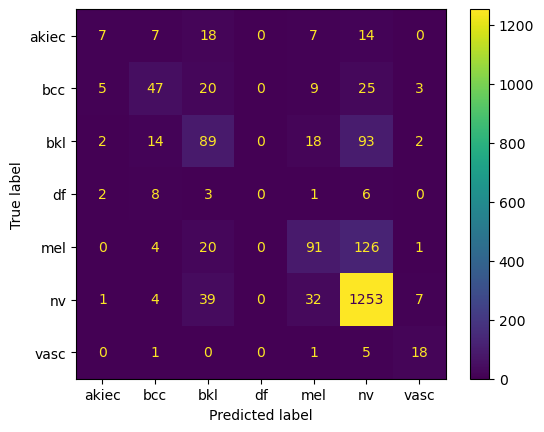

In [11]:
cm = confusion_matrix(name_as_indexes_test,y_pred)
ConfusionMatrixDisplay(cm,display_labels=class_names).plot()
plt

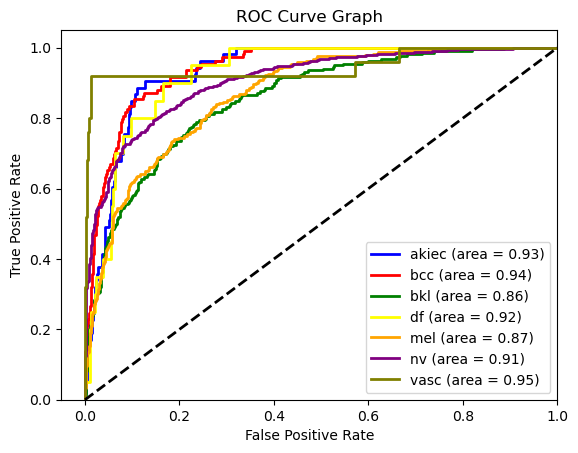

In [12]:
make_roc_curve(preds)